# Project 2 Human Detection

Ken Iiyoshi (ki573)

18 Oct 2019

Instructor: Tadesse Mulugeta



# How to Run

To run the code below, execurte this notebook in Jupyer Notebook.

# HOG Descriptor

In [1]:
#imports
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import colors

prewritt_x =np.array([[1,0,-1],
                               [1,0,-1],
                               [1,0,-1]]);

prewritt_y =np.array([[1,1,1],
                             [0,0,0],
                             [-1,-1,-1]]);

gaussian =np.array([[1,1,2,2 ,2,1,1],
                    [1,2,2,4 ,2,2,1],
                    [2,2,4,8 ,4,2,2],
                    [2,4,8,16,8,4,2],
                    [2,2,4,8 ,4,2,2],
                    [1,2,2,4 ,2,2,1],
                    [1,1,2,2 ,2,1,1]]);


In [2]:
# function definitions

def filter (array,mask):
    kernel_sz = mask.shape[0];
    pad_sz = math.floor(kernel_sz/2);
    padded = np.zeros((array.shape[0]+2*pad_sz, array.shape[1]+2*pad_sz)).astype(int);
    
    # copy array content to padded matrix
    padded[pad_sz:pad_sz+array.shape[0],pad_sz:pad_sz+array.shape[1]]=array;
    
    # Put result in new array. Otherwise cv2-imported array will invert negative to positive.
    after_conv = np.zeros((array.shape)).astype(int)
    # convolve
    for i in range(pad_sz,padded.shape[0]-pad_sz):
        for j in range(pad_sz,padded.shape[1]-pad_sz):
            # cut out a window to input feed into convolution function. +1 for proper range
            window=np.zeros((mask.shape)).astype(int);
            window=padded[i-pad_sz:i+pad_sz+1,j-pad_sz:j+pad_sz+1];
    
            # prewitt filter (horizontal/vertical), otherwise gaussian
            if np.array_equal(mask,prewritt_x) or np.array_equal(mask,prewritt_y):
                after_conv[i-pad_sz][j-pad_sz]=np.sum(np.multiply(window,mask));
            else:
                after_conv[i-pad_sz][j-pad_sz]=np.sum(np.multiply(window,mask))/np.sum(np.absolute(mask)); 
    return after_conv

def calc_hog(img_file_name, cell_sz, block_sz, bins, overlap):
    # read color image
    in_img = cv2.imread(img_file_name);

    # rgb to grayscale conversion.
    gray = np.zeros((in_img.shape[0],in_img.shape[1])).astype(int);
    for i in range(gray.shape[0]):
            for j in range(gray.shape[1]):
                # using the formula I = (0.299R+0.587G+0.114B)
                gray[i][j] = 0.299*in_img[i][j][0] + 0.587*in_img[i][j][1] + 0.114*in_img[i][j][2];

    # declare image variables based on input image size
    G_mag = np.zeros((gray.shape)).astype(int);
    G_ang = np.zeros((gray.shape)).astype(int);

    # Gaussian Smoothing
    smooth = filter(gray,gaussian)
    
    # Gradient Operation
    G_x = filter(smooth,prewritt_x);
    G_y = filter(smooth,prewritt_y);

    # Gradient Magnitude and Angle (0 to 180)
    for j in range(gray.shape[0]):
        for i in range(gray.shape[1]):
            G_mag[j][i]=int((G_x[j][i]**2+G_y[j][i]**2)**(1/2));
            if (G_x[j][i]!=0):
                # range is (0,90) if G_y/G_x > 0
                if G_y[j][i]/G_x[j][i] > 0:
                    #arctan is in radians. multiply by 180/pi dy/dx
                    G_ang[j][i] = (180/math.pi)*np.arctan(G_y[j][i]/G_x[j][i]);
                # range is (90,180) map from (-90,0)
                else:
                    G_ang[j][i] = 180 + (180/math.pi)*np.arctan(G_y[j][i]/G_x[j][i]);
            #if G_x=0, result is  90 unless G_y is also 0/
            elif (G_y[j][i] != 0):
                G_ang[j][i]=90;
            else:
                G_ang[j][i]=0

    # normalize G_mag:
    G_mag = G_mag/np.max(G_mag) * 255;
    G_mag = G_mag.astype(int);

    # peripheral calculation
    cells_per_block = int((block_sz/cell_sz)**2);
    bins_per_block = bins*cells_per_block
    block_d_sz = bins*cells_per_block; # number of descriptors per block

    # calculate descriptor dimension
    hog_y = int((G_mag.shape[0] - block_sz)/overlap + 1);
    hog_x = int((G_mag.shape[1] - block_sz)/overlap + 1);

    # create cells 
    cells_y = int(G_mag.shape[0]/cell_sz);
    cells_x = int(G_mag.shape[1]/cell_sz);
    cells = np.zeros((cells_y,cells_x,bins)).astype(int);
    
    # populate cell histogram. each cell's index is relative to its top-left-most pixel.
    for j in range(cells.shape[0]):
        for i in range(cells.shape[1]):
            cell_ang = np.zeros((cell_sz,cell_sz)).astype(int);
            cell_mag = np.zeros((cell_sz,cell_sz)).astype(int);
            # set cell
            cell_ang = G_ang[j*cell_sz:j*cell_sz + cell_sz,i*cell_sz:i*cell_sz + cell_sz];
            cell_mag = G_mag[j*cell_sz:j*cell_sz + cell_sz,i*cell_sz:i*cell_sz + cell_sz];

            # Fill the histogram in this cell
            for y in range(cell_ang.shape[1]):
                for x in range(cell_ang.shape[0]):
                    # calculate distance_weighted ratio:
                    ratio_r = cell_ang[y][x]%20/20; # for right bin
                    ratio_l = 1 - ratio_r; # for left bin

                    # populate the 9 bins that ranges from [0,20), [20,40),...,[160,180)
                    # the corresponding centers are 10, 30, ..., 170
                    if (cell_ang[y][x] >= 170) or (cell_ang[y][x] < 10):
                        cells[j][i][bins - 1] = cells[j][i][bins - 1] + cell_mag[y][x]*ratio_l;
                        cells[j][i][0] = cells[j][i][0] + cell_mag[y][x]*ratio_r;
                    for n in range(1,bins):   
                        if (cell_ang[y][x] >= -10+n*20) and (cell_ang[y][x] < 10 + n*20):
                            cells[j][i][n-1] = cells[j][i][n-1] + cell_mag[y][x]*ratio_l;
                            cells[j][i][n] = cells[j][i][n] + cell_mag[y][x]*ratio_r;

    # create hog
    hog_input = np.zeros((hog_y,hog_x, bins_per_block));

    # Note that the number of descriptors is 19*11*36 = 7524. (209 sets of 36 descriptors)
    # Whereas the number of pixels in the input image is 160*96 = 15,360.

    # populate hog
    for j in range(hog_input.shape[0]):
        for i in range(hog_input.shape[1]):
            hog_input[j][i][0:9]=cells[j][i];
            hog_input[j][i][9:18]=cells[j][i+1];
            hog_input[j][i][18:27]=cells[j+1][i];
            hog_input[j][i][27:36]=cells[j+1][i+1];

            # normalize resulting concatenated historgram
            if ((np.sum((hog_input[j][i])**2)**(1/2)) != 0):
                hog_input[j][i] = hog_input[j][i]/(np.sum((hog_input[j][i])**2)**(1/2))

    # sanity check: cell
    cell_img = np.zeros((cells.shape[0],cells.shape[1])).astype(int);
    for j in range(cells.shape[0]):
            for i in range(cells.shape[1]):
                cell_img[j][i] = np.sum(cells[j][i]);

    # normalize cell_img:
    cell_img = cell_img/np.max(cell_img) * 255;
    cell_img = cell_img.astype(int);            

    # plot hog process for the image. raw size.
    fig = plt.figure(figsize=(15,4.5));
    fig.suptitle(img_file_name, fontsize=12)

    # "A" will be normalized here, so it must be reinitialized if the code is to be reran.
    plt.subplot(1,5,1)
    plt.title('in_img');
    plt.imshow(cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)); 

    plt.subplot(1,5,2)
    plt.title('smooth gray');
    plt.imshow(smooth, cmap = "gray"); 

    plt.subplot(1,5,3)
    plt.title('G_mag');
    plt.imshow(G_mag, cmap = "gray"); 
    
    plt.subplot(1,5,4)
    plt.title('HOG cell sum');
    plt.imshow(cell_img, cmap = "gray"); 

    # to check if the hog image looks correct (i.e. darker on pixels with less G_mag),
    # the results are compared with scikit-learn's hog function output.
    from skimage.feature import hog
    from skimage import data, exposure

    fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, block_norm="L2")

    # normalize sk image so it saves as a visible image:
    hog_image = hog_image/np.max(hog_image) * 255;
    hog_image = hog_image.astype(int);

    plt.subplot(1,5,5)
    plt.title('SKLearn HOG');
    plt.imshow(hog_image, cmap="gray");

    return hog_input

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


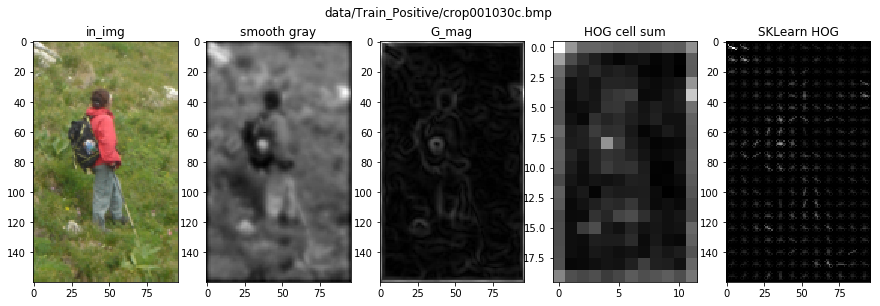

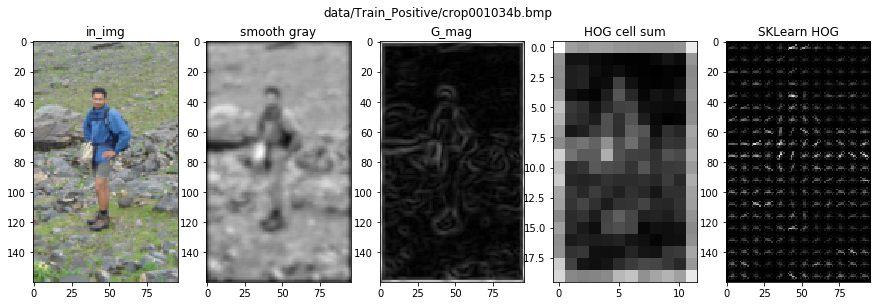

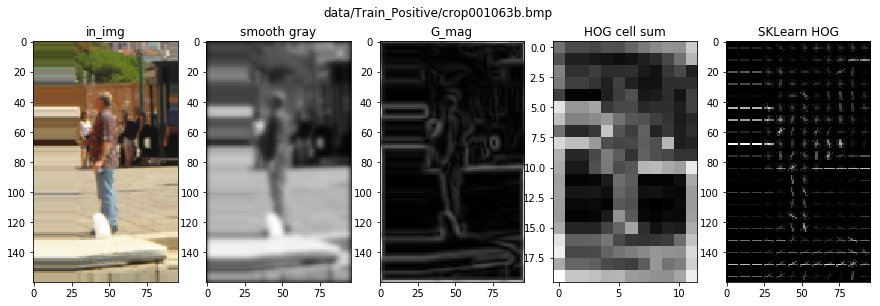

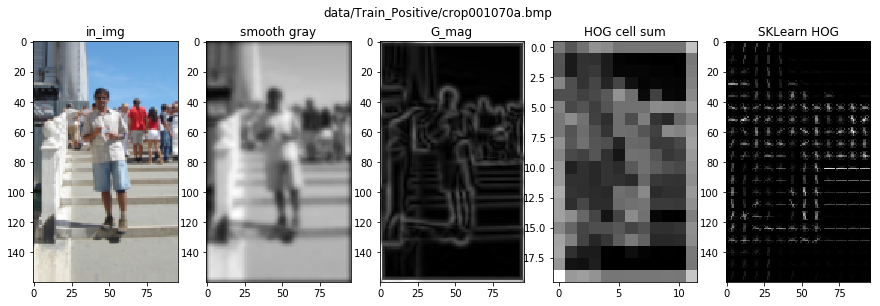

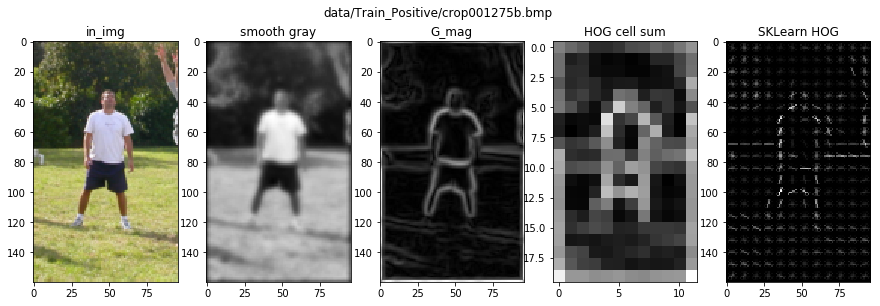

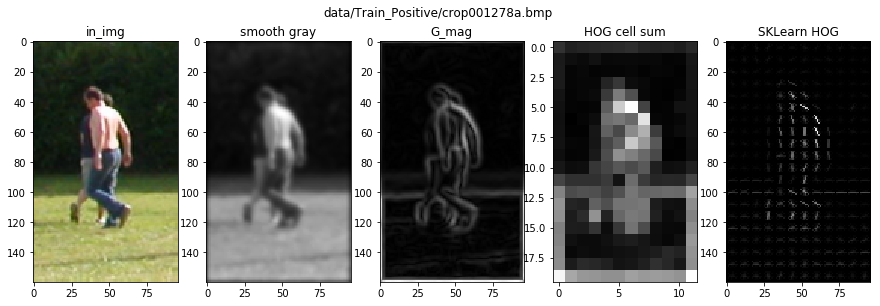

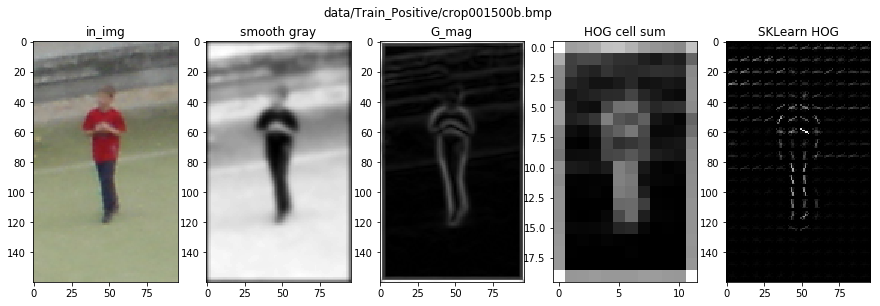

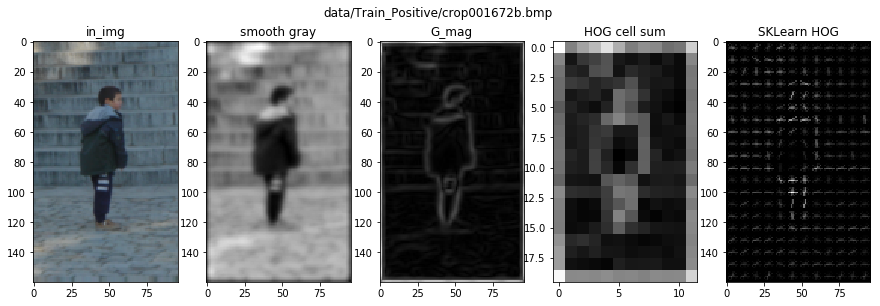

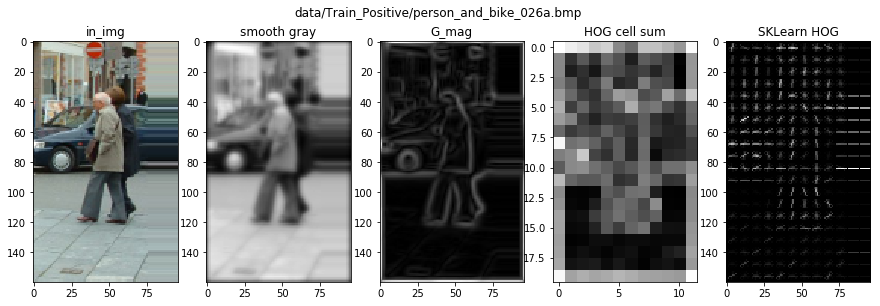

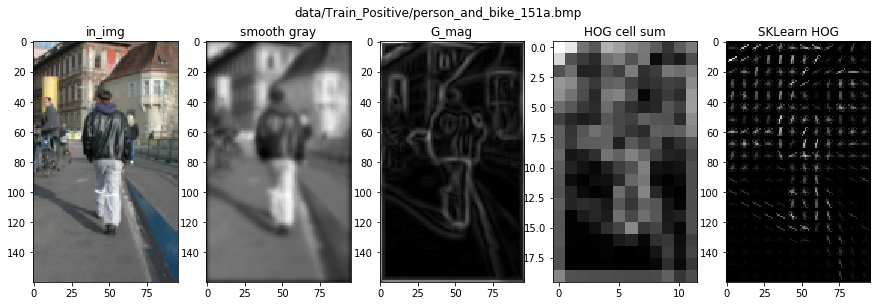

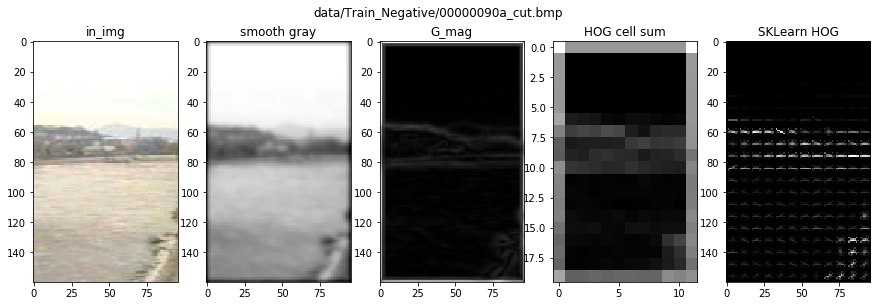

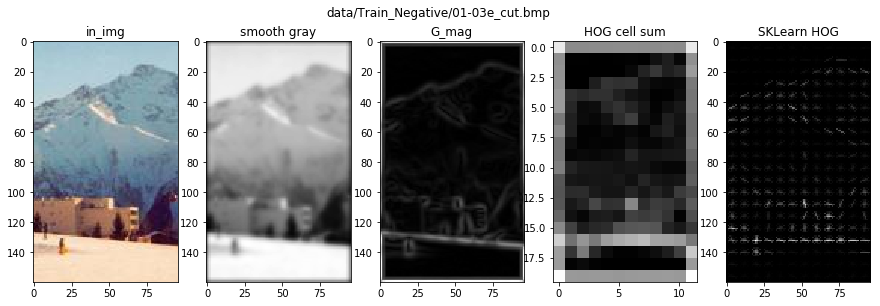

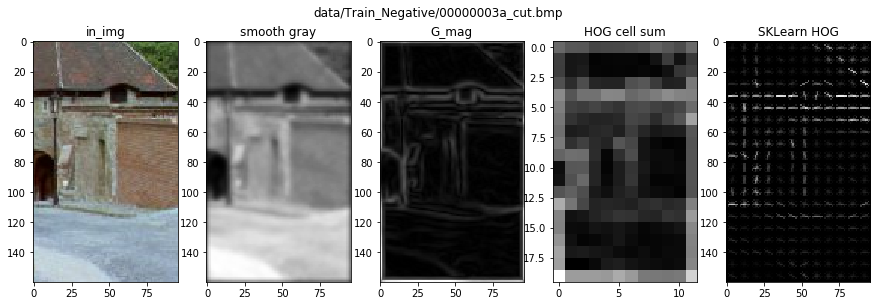

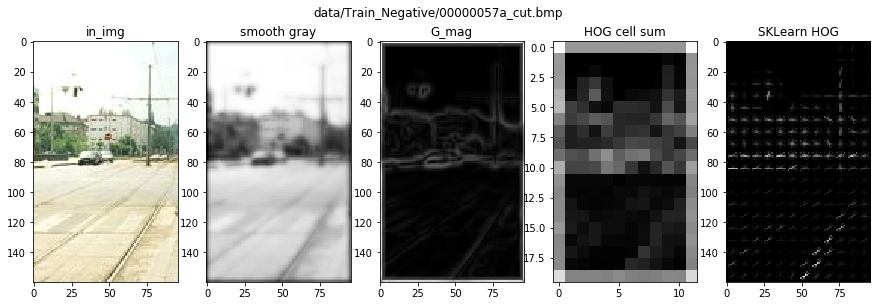

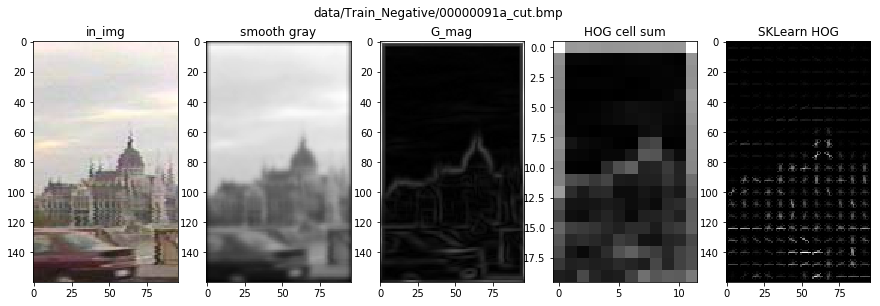

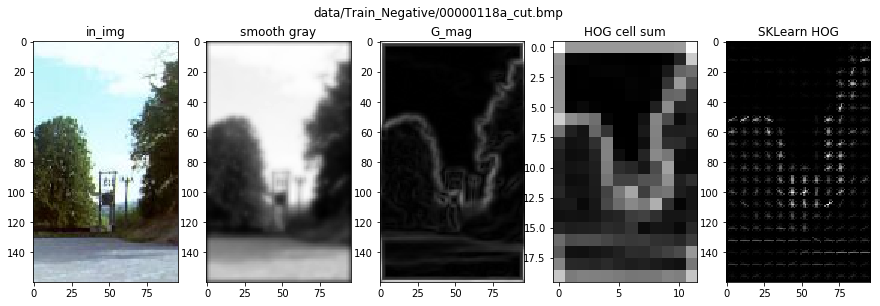

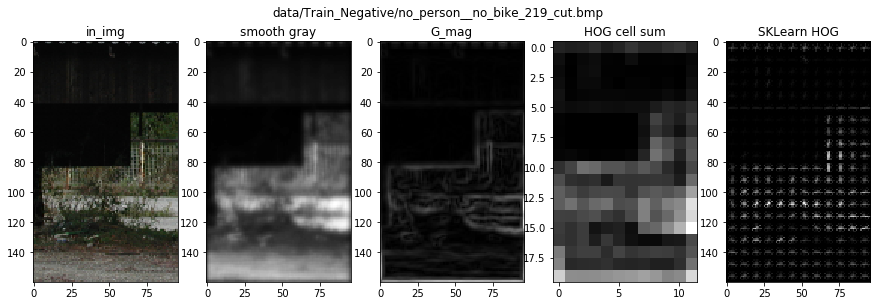

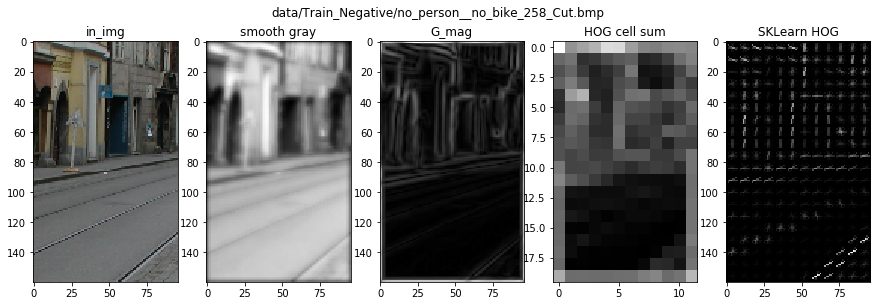

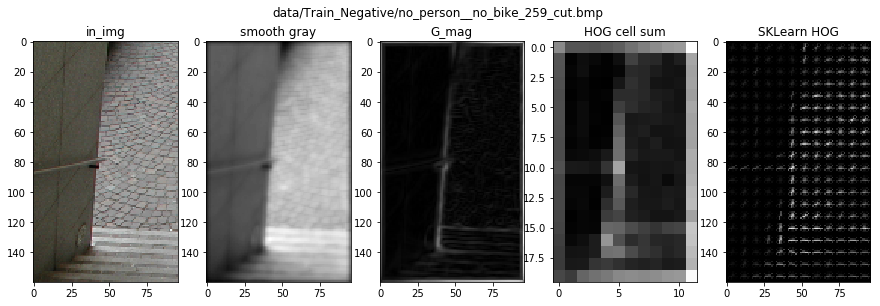

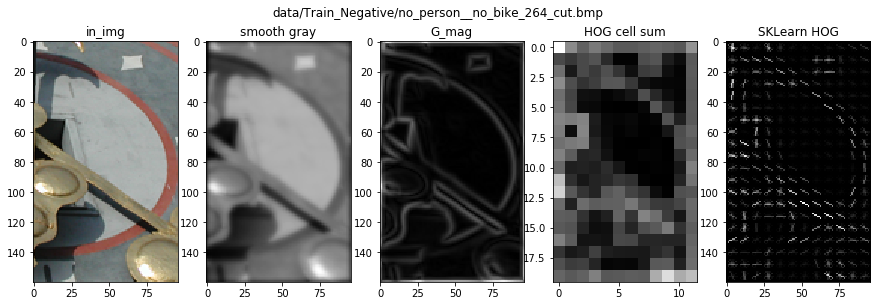

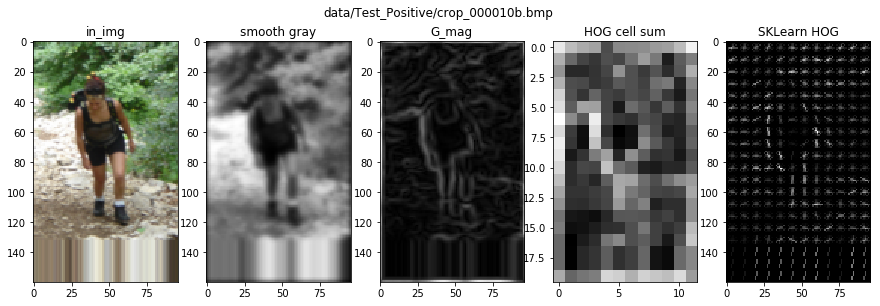

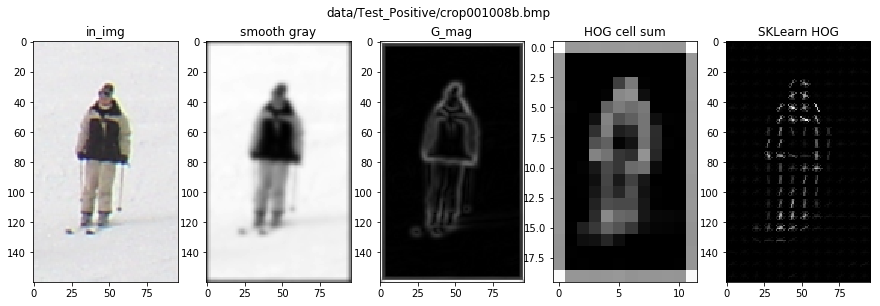

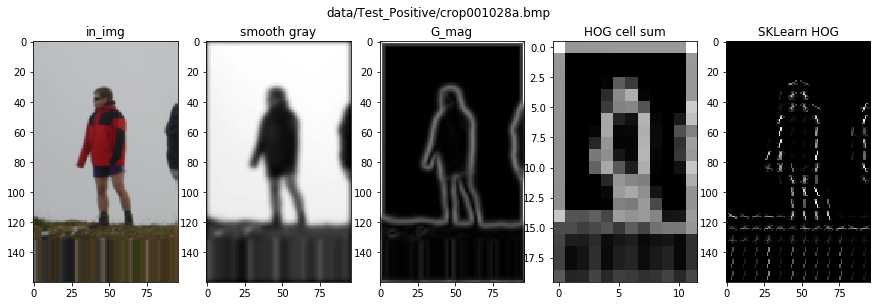

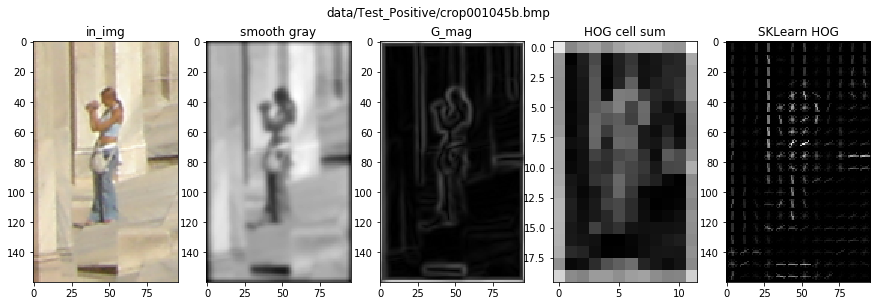

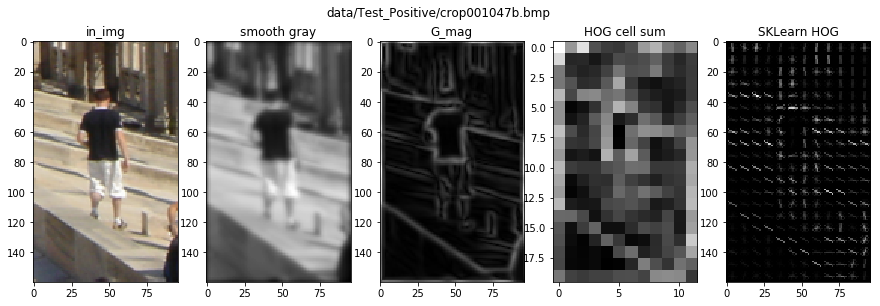

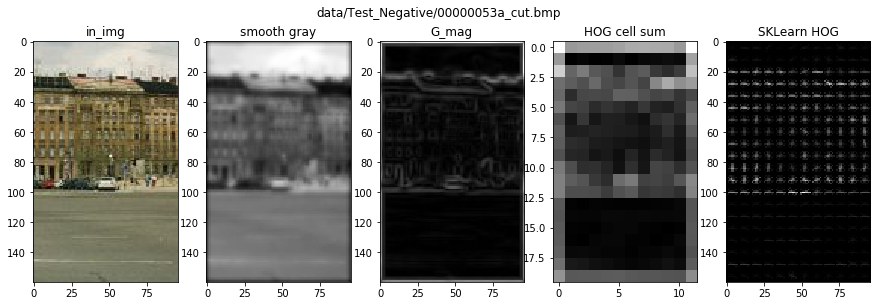

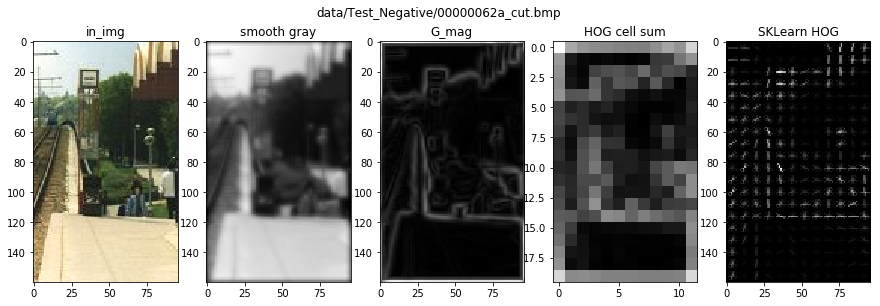

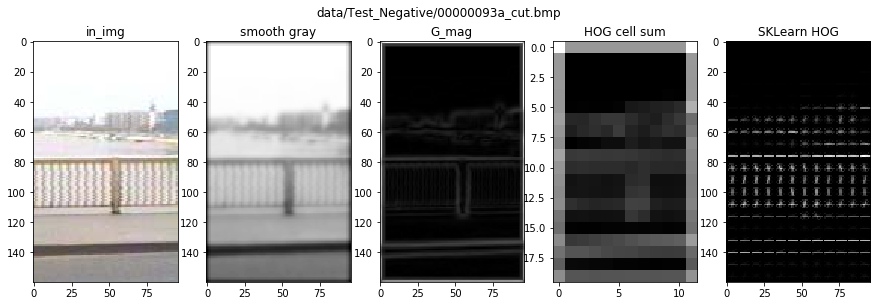

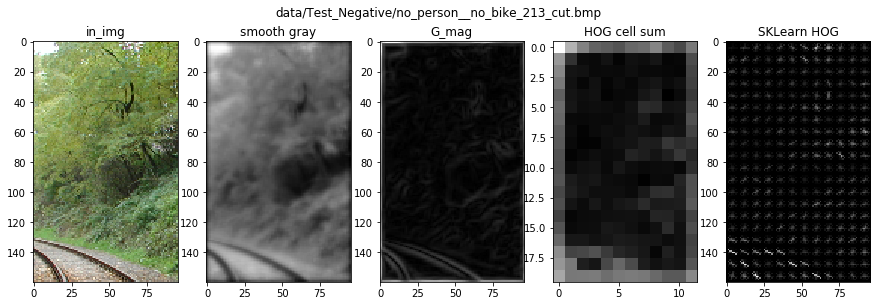

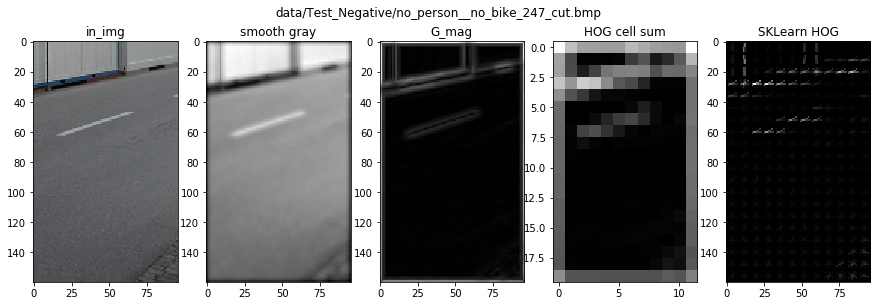

In [3]:
# set descriptor parameters
cell_sz = 8;    # pixels
block_sz = 16;  # pixels
bins = 9; # per cell
overlap = 8; # block overlap

file_list = [];
# insert all training images
# positive
file_list.append("data/Train_Positive/crop001030c.bmp");
file_list.append("data/Train_Positive/crop001034b.bmp");
file_list.append("data/Train_Positive/crop001063b.bmp");
file_list.append("data/Train_Positive/crop001070a.bmp");
file_list.append("data/Train_Positive/crop001275b.bmp");
file_list.append("data/Train_Positive/crop001278a.bmp");
file_list.append("data/Train_Positive/crop001500b.bmp");
file_list.append("data/Train_Positive/crop001672b.bmp");
file_list.append("data/Train_Positive/person_and_bike_026a.bmp");
file_list.append("data/Train_Positive/person_and_bike_151a.bmp");
# negative
file_list.append("data/Train_Negative/00000090a_cut.bmp");
file_list.append("data/Train_Negative/01-03e_cut.bmp");
file_list.append("data/Train_Negative/00000003a_cut.bmp");
file_list.append("data/Train_Negative/00000057a_cut.bmp");
file_list.append("data/Train_Negative/00000091a_cut.bmp");
file_list.append("data/Train_Negative/00000118a_cut.bmp");
file_list.append("data/Train_Negative/no_person__no_bike_219_cut.bmp");
file_list.append("data/Train_Negative/no_person__no_bike_258_Cut.bmp");
file_list.append("data/Train_Negative/no_person__no_bike_259_cut.bmp");
file_list.append("data/Train_Negative/no_person__no_bike_264_cut.bmp");
# include test images as well
file_list.append("data/Test_Positive/crop_000010b.bmp");
file_list.append("data/Test_Positive/crop001008b.bmp");
file_list.append("data/Test_Positive/crop001028a.bmp");
file_list.append("data/Test_Positive/crop001045b.bmp");
file_list.append("data/Test_Positive/crop001047b.bmp");
file_list.append("data/Test_Negative/00000053a_cut.bmp");
file_list.append("data/Test_Negative/00000062a_cut.bmp");
file_list.append("data/Test_Negative/00000093a_cut.bmp");
file_list.append("data/Test_Negative/no_person__no_bike_213_cut.bmp");
file_list.append("data/Test_Negative/no_person__no_bike_247_cut.bmp");

# simply save this entire notebook to show results offline.

# Now, prepare use my hog dataset
nn_input = [];
for img_file_name in file_list:
    
    # get img_file_name's hog
    hog_input = calc_hog(img_file_name, cell_sz, block_sz, bins, overlap);
    
    hog_input = np.ndarray.tolist(hog_input); # convert from ndarray to list
    
    # convert length*width*bins per block to simply array of size(total descriptor)
    # combine across rows
    hog_input = sum(hog_input,[]);
    # combine across columns
    hog_input = sum(hog_input,[]);

    # append 1 or 0 signifying if there is human in the image or not
    # to do this, check if the image is is in positive folder or not 
    split_list = [];
    split_list = img_file_name.split("/")
    if (split_list[1] == "Train_Positive") or (split_list[1] == "Test_Positive"):
        hog_input.append(1);
    else:
        hog_input.append(0);
    
    nn_input.append(hog_input);



# HOG Result

All 30 images were processed successfully, as shown above. To check that the HOG descriptors were correctly made, each of the 9 HOG descriptors in each cell were summed and displayed for comparison with a HOG visualization made from Sci-Kit Learn's built-in function.

# Neural Network

In [4]:
# import 
from random import seed
from random import random

In [5]:
def init_nn(n_input,n_hidden,n_output):
    nn = [];
    nn.append([{'W':[random() for i in range(n_input + 1)]} for i in range(n_hidden)])
    nn.append([{'W':[random() for i in range(n_hidden + 1)]} for i in range(n_output)])
    return nn

def calc_z(W,inputs):
    z = W[-1]; # add noise first
    
    # for weights (except the noise) that contributes to the target node
    for i in range(len(W)-1): z += W[i]*inputs[i] ;
    
    return z

# return f(z)=sigmoid(z)
def activate(z): return 1 / (1 + np.exp(-z))

def forward_prop(nn,inputs):
    for layer in nn:
        next_inputs = [];
        for neuron in layer:
            z = calc_z(neuron["W"],inputs);
            neuron["f(z)"]= activate(z); # adds item to the dict
            next_inputs.append(neuron["f(z)"]);
        inputs = next_inputs;
    return inputs;


In [6]:
# back propagation
def d_activate(output): return output * (1.0 - output);

# Backpropagate error and store in neurons
def find_delta(nn, expected):
    # reverse direction
    for i in reversed(range(len(nn))):
        layer = nn[i];
        errors = [];
        # if in hidden layer
        if i != len(nn)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in nn[i + 1]:
                    error += (neuron['W'][j] * neuron['delta'])
                errors.append(error)
        # if in output layer
        else:
            for j in range(len(layer)):
                neuron = layer[j];
                errors.append(expected[j] - neuron['f(z)']);
        # populate delta
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * d_activate(neuron['f(z)'])    
    return None

# update weights with error
def update_weights(nn, row, alpha):
    for i in range(len(nn)):
        inputs = row[:-1]
        # for non-input layers, set inputs as acivated output from previous layer 
        if i != 0:
            inputs = [neuron['f(z)'] for neuron in nn[i - 1]]
        # for i_th layer
        for neuron in nn[i]:
            # update weights
            for j in range(len(inputs)):
                neuron['W'][j] += alpha * neuron['delta'] * inputs[j]
            neuron['W'][-1] += alpha * neuron['delta'] # update bias
            
# using stochastic gradient descent to train a network for a fixed number of epochs.
# n_epoch is the number of iterations for gradient descent of a set of traning data.
def train_network(nn, train, alpha, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        sum_error = 0
        count = 0 # for printing rows
        for row in train:
            count += 1; # for tracking what row to print
            
            # find output (1 hot encoded i.e. close to [1,0] ~ [0,1] )
            outputs = forward_prop(nn, row)
            
            # initialize array of "expected" values
            expected = [0 for i in range(n_outputs)]
            
            # set first or second index to 1, i.e. ([1,0]) or [0,1], depending on Y value. 1 hot encoding
            expected[row[-1]] = 1;
            
            # add ouput error (0 if correct, 1 if incorrect) to sum of error over all data
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            
            #back propagation
            find_delta(nn, expected)
            
            # update weights
            update_weights(nn, row, alpha)

    return None;


In [7]:
from random import randrange
    
# Make a prediction with a network
def predict(nn, row):
    outputs = forward_prop(nn, row)
    return outputs.index(max(outputs)) # selects most probable class
# Split a dataset into k folds
def k_split(data, n_folds):
    
    # list of splitted data to be returned
    data_split = [];
    
    data_copy = list(data);
    
    # find fold_size
    fold_size = int(len(data) / n_folds)

    # for each fold randomly move data row from data into the i_th fold fold_size times.
    for i in range(n_folds):
        fold = [];
        while len(fold) < fold_size: fold.append(data_copy.pop(randrange(len(data_copy))));
        # append the fold as 1 entry
        data_split.append(fold)
    
    return data_split
 
# Find accuracy rate
def percent_accuracy(actual, predicted):
    correct = 0;
    for i in range(len(actual)):
        if actual[i] == predicted[i]: correct += 1;
    return correct / float(len(actual)) * 100.0
 
# Evaluate performance of the neural network using leave-one-out cross validation split
# argument pointer becomes handy
def nn_perf(dataset, n_folds, *args):
    
    # split data into n folds of list entries
    folds = k_split(dataset, n_folds)    
    print(len(dataset), "dataset images with", len(folds), "folds:", int(len(dataset)/len(folds)), "images per fold")

    # keep score for each split
    scores = [];
    count = 0
    # for each fold:
    for fold in folds:
        count+=1;
        print("Working on fold "+ str(count) + " ...")
        
        # copy folds into train_set
        train_set = list(folds)
        
        # remove the i_th fold
        train_set.remove(fold);
        
        # recombine the folds as inputs. Note that [] is dropped after the recombination.
        train_set = sum(train_set, [])
        
        # copy fold into test_set by row. set each class output to None.
        test_set = [];
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
            
        # do back_propagation
        predicted = back_propagation(train_set, test_set, *args)
       
        # make an array for true output classes
        actual = [row[-1] for row in fold];
        
        # calculate accuracy and append to score.
        scores.append(percent_accuracy(actual, predicted));
        
    return scores

# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, alpha, n_epoch, n_hidden):
    
    # assign number of input features as n_inputs 
    n_inputs = len(train[0]) - 1;
    
    # Set n_ouputs based on the number of output class
    n_outputs = len(set([row[-1] for row in train]));
    
    # Initialize network
    network = init_nn(n_inputs, n_hidden, n_outputs);
    
    # train network
    train_network(network, train, alpha, n_epoch, n_outputs);
    
    predictions = [];
    
    # for each data enty, predict output
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    # return predictions for all test data.
    return(predictions)

Design a two-layer perceptron for classifying the images represented by their HOG descriptor into human or no-human. The perceptron will have an input layer of size N, with N being the size of the HOG descriptor, a hidden layer and an output layer with one output neuron. Try hidden layer sizes of 250, 500 and 1,000 neurons and report the classification results. (Optional: you can try other hidden layer sizes and report the results if you get better results than the three above.) Use the ReLU activation function for neurons in the hidden layer and the Sigmoid function for the output neuron. The Sigmoid function will ensure that the output is within the range [0,1], which can be interpreted as the probability of having detected human in the image. Use the backpropagation rule we covered in lecture for training multi-layer perceptrons.

Training and test images: A set of 20 training images, containing 10 positive (human) and 10 negative (no human) samples, and a set of 10 test images containing 5 positive and 5 negative samples will be provided. You should assign an output label of 1 for training images containing human and 0 otherwise.

In [8]:
seed(0);
n_folds = 5; l_rate = 0.5; n_epoch = 20; n_hidden = 5;
score = nn_perf(nn_input, n_folds, l_rate, n_epoch, n_hidden)
print('Avg Accuracy: %.3f%%' % (sum(score)/n_folds));

30 dataset images with 5 folds: 6 images per fold
Working on fold 1 ...
Working on fold 2 ...
Working on fold 3 ...
Working on fold 4 ...
Working on fold 5 ...
Avg Accuracy: 43.333%


In [9]:
seed(0);
n_folds = 5; l_rate = 0.5; n_epoch = 20; n_hidden = 10;
score = nn_perf(nn_input, n_folds, l_rate, n_epoch, n_hidden)
print('Avg Accuracy: %.3f%%' % (sum(score)/n_folds));

30 dataset images with 5 folds: 6 images per fold
Working on fold 1 ...
Working on fold 2 ...
Working on fold 3 ...
Working on fold 4 ...
Working on fold 5 ...
Avg Accuracy: 43.333%


In [10]:
seed(0);
n_folds = 5; l_rate = 0.5; n_epoch = 20; n_hidden = 15;
score = nn_perf(nn_input, n_folds, l_rate, n_epoch, n_hidden)
print('Avg Accuracy: %.3f%%' % (sum(score)/n_folds));

30 dataset images with 5 folds: 6 images per fold
Working on fold 1 ...
Working on fold 2 ...
Working on fold 3 ...
Working on fold 4 ...
Working on fold 5 ...
Avg Accuracy: 50.000%


# Neural Network Result

Due to lack of GPU available on the final day, offline CPU was used for classification. This limited the number of neurons to be used for the hidden layer. The average accuracy of my neural network with 5, 10, and 15 hidden layers were 43.3%, 43.3%, and 50% respectively. In general, increasing the number of neurons in the hidden layer improved the accuracy. The number of folds was limited to 5 for saving computation time. The best learning rate was assumed to be 0.5.  The epoch was limited to 20 since the decrease in error saturated after that for most folds and was not worth the extra computation time. The best accuracy achieved was 50%, which is no better than random guessing given equal ratio of human and non-human images.